### AutoEncoderの学習<br>
from https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from PIL import Image
import time
import os
import time
import pdb
import glob

# proxyの設定．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader


from torch.autograd import Variable
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans

In [3]:
#Converting data to torch.FloatTensor
transform = transforms.ToTensor()

# Download the training and test datasets
train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)

test_data = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
#Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0)

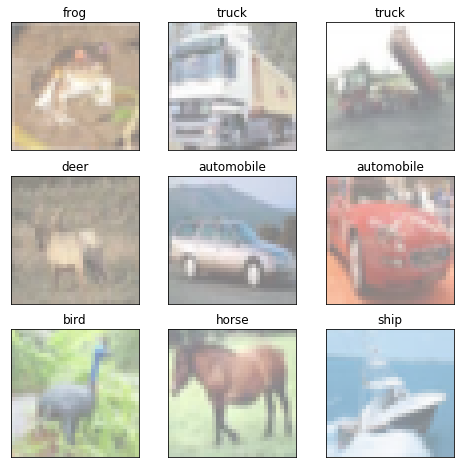

In [5]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

#Define the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [6]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        encoder = self.pool(x)
        x = F.relu(self.t_conv1(encoder))
        decoder = torch.sigmoid(self.t_conv2(x))
              
        return encoder, decoder


#Instantiate the model
model = ConvAutoencoder()
print(model)


ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [7]:
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

In [9]:
#Epochs
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        encoded, outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

/usr/local/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 18.953575
Epoch: 2 	Training Loss: 18.457908
Epoch: 3 	Training Loss: 18.368568
Epoch: 4 	Training Loss: 18.343044
Epoch: 5 	Training Loss: 18.325267
Epoch: 6 	Training Loss: 18.307202
Epoch: 7 	Training Loss: 18.292436
Epoch: 8 	Training Loss: 18.283160
Epoch: 9 	Training Loss: 18.275691
Epoch: 10 	Training Loss: 18.268980
Epoch: 11 	Training Loss: 18.264424
Epoch: 12 	Training Loss: 18.261432
Epoch: 13 	Training Loss: 18.259211
Epoch: 14 	Training Loss: 18.257460
Epoch: 15 	Training Loss: 18.256003
Epoch: 16 	Training Loss: 18.254751
Epoch: 17 	Training Loss: 18.253442
Epoch: 18 	Training Loss: 18.252265
Epoch: 19 	Training Loss: 18.251229
Epoch: 20 	Training Loss: 18.250324
Epoch: 21 	Training Loss: 18.249516
Epoch: 22 	Training Loss: 18.248736
Epoch: 23 	Training Loss: 18.247996
Epoch: 24 	Training Loss: 18.247371
Epoch: 25 	Training Loss: 18.246813
Epoch: 26 	Training Loss: 18.246289
Epoch: 27 	Training Loss: 18.245806
Epoch: 28 	Training Loss: 18.245369
E

In [11]:
#model save
torch.save(model.state_dict(), "model.pkl")

Original Images


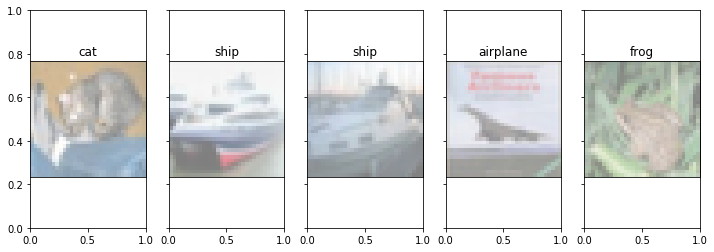

Reconstructed Images


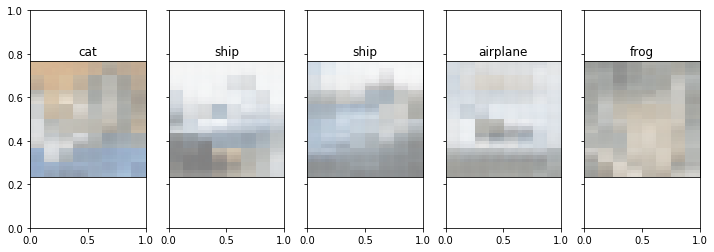

In [16]:
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)
#Sample outputs
encoded, output = model(images)
images = images.cpu().numpy()

output = output.view(32, 3, 32, 32)
output = output.detach().cpu().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 

### k-meansクラスタリング<br>
k= 5

In [17]:
classify_loader = torch.utils.data.DataLoader(test_data, batch_size=100, num_workers=0)

In [18]:
#Batch of test images
dataiter = iter(classify_loader)
images, labels = dataiter.next()
images = images.to(device)
#Sample outputs
encoded, output = model(images)
print(encoded.cpu().detach().numpy().shape)

(100, 4, 8, 8)


In [19]:
#flatten
test = encoded.cpu().detach()
test= torch.flatten(test,start_dim=1).numpy()
test.shape

(100, 256)

In [27]:
kmeans_model_k5 = KMeans(n_clusters=5).fit_predict(test)

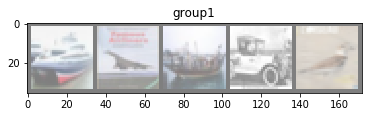

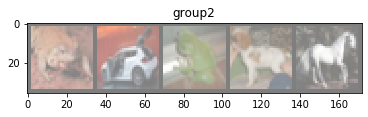

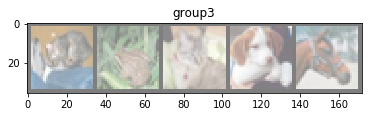

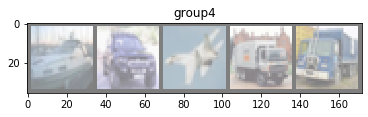

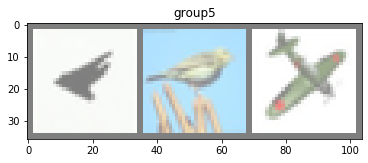

In [30]:
for i in range(5):
    plt.title('group'+ str(i+1))
    imshow(torchvision.utils.make_grid(images[kmeans_model_k5 == i][0:5].cpu()).numpy())
    plt.show()

### k-meansクラスタリング<br>
k= 10

In [31]:
kmeans_model_k10 = KMeans(n_clusters=10).fit_predict(test)

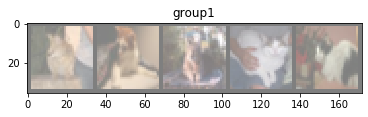

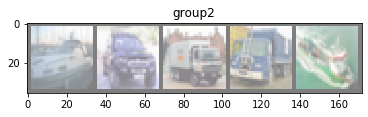

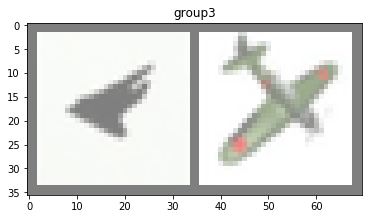

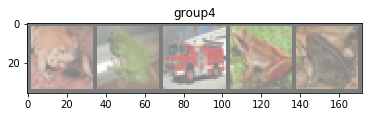

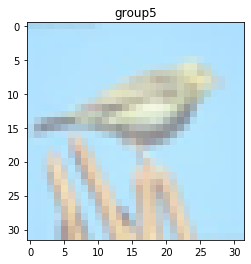

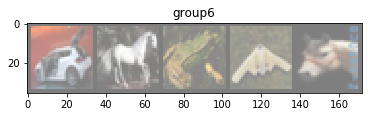

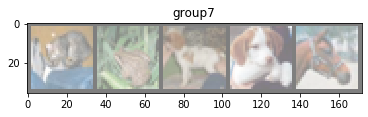

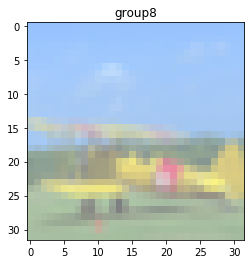

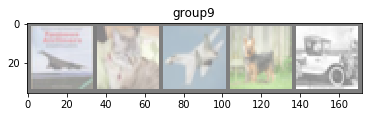

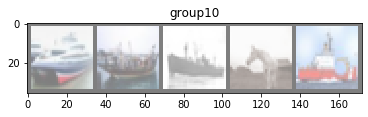

In [33]:
for i in range(10):
    plt.title('group'+ str(i+1))
    imshow(torchvision.utils.make_grid(images[kmeans_model_k10 == i][0:5].cpu()).numpy())
    plt.show()

オートエンコーダーの学習は、100エポックしか行っていないので、解像度もロスもまだ大きいなと感じた。クラスから画像を生成するので、粗い画像でもかなり学習に時間がかかりそうだ。　<br>
k-meansでは色味と形で区分されているように感じた。k=5でもk=10でも、車はどの分類にも入りやすく、生物（特に猫や犬、馬）はまとまって分類されているように感じた。k-meansは計算によって区分されているので、精度はまあまあだろうが、計算スピードが早いので、画像情報でなく数的情報を扱う時には優位かもしれない。